## Evolving gaussians experiments

In [44]:
%cd evolving_gaussians

[Errno 2] No such file or directory: 'evolving_gaussians'
/users/eleves-b/2020/basile.terver/Spatio-temporal-alignments/spatio-temporal-alignements/evolving_gaussians


/Data/basile-terver/venvs/.venv_sta/lib64/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [45]:
def get_expe_filename(num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types):
    return "tsne-gaussians_ns{}_nt{}_b{}_s{}_ng{}_{}.pkl".format(
        num_samples_per_class, num_timesteps, "_".join(map(str, betas)),
        "_".join(map(str, speeds)), "_".join(map(str, num_gaussians)),
        "_".join(map(str, evolution_types))
    )

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def generate_gaussian_mixture_data(num_samples_per_class=5, num_timesteps=250, support_size=150, num_gaussians=[1, 3], evolution_types=["linear", "circular"], speeds=[1.0, -1.0], seed=None):
    np.random.seed(seed)
    
    # Generate time values, time normalized in [0,1] interval
    time_values = np.linspace(0, 1, num_timesteps)

    # Initialize data array
    num_classes = len(evolution_types) * len(speeds) * len(num_gaussians)
    data = np.zeros((num_classes, num_samples_per_class, num_timesteps, support_size))

    # Initialize label arrays
    y_speed = []
    y_evotype = []
    y_numgaussians = []

    for speed_idx, speed in enumerate(speeds):
        for evolution_idx, evolution_type in enumerate(evolution_types):
            for num_gaussian_idx, num_gaussian in enumerate(num_gaussians):
                for sample_idx in range(num_samples_per_class):
                    if num_gaussian==2:
                        means=np.array([np.random.uniform(support_size/5, 2*support_size/5),np.random.uniform(3*support_size/5, 4*support_size/5)])
                    else:
                        means = np.random.uniform(support_size/5, 4*support_size/5, num_gaussian)
                    std_devs = np.random.uniform(5, 10, num_gaussian)

                    # Assign labels based on the current configuration
                    y_speed.append(speed)
                    y_evotype.append(evolution_type)
                    y_numgaussians.append(num_gaussian)

                    for t, time in enumerate(time_values):
                        # Update means based on movement
                        if evolution_type == "linear":
                            means += speed
                        elif evolution_type == "circular":
                            means = (means + speed) % support_size
                        else:
                            raise ValueError("Invalid evolution_type. Use 'linear' or 'circular'.")
                        
                        # Evaluate Gaussian mixture PDF at each point in the support for each component
                        component_pdfs = norm.pdf(np.arange(support_size)[:, None], loc=means, scale=std_devs)
                        
                        # Sum the probabilities across components
                        mixture_pdf = np.sum(component_pdfs, axis=1)
                        class_idx = (speed_idx * len(evolution_types) + evolution_idx) * len(num_gaussians) + num_gaussian_idx
                        data[class_idx, sample_idx, t, :] = mixture_pdf / np.sum(mixture_pdf)

    return data,y_speed, y_evotype, y_numgaussians


In [47]:
def plot_samples(data, num_snapshots=5, samples_per_class_to_plot=1, y_speed=None, y_evotype=None, y_numgaussians=None,\
                 speeds=[1.0, -1.0],num_gaussians=[1,3],evolution_types=["linear", "circular"]):
    
    num_classes, num_samples_per_class, num_timesteps, support_size = data.shape
    snapshot_indices = np.linspace(0, num_timesteps - 1, num_snapshots, dtype=int)

    
    dateset_plot_filename_png = "data/dataset_plot_ns{}_nt{}_s{}_ng{}_{}.png".format(
        num_samples_per_class, num_timesteps,
        "_".join(map(str, speeds)), "_".join(map(str, num_gaussians)),
        "_".join(map(str, evolution_types))
    )

    plt.figure(figsize=(12, 12))

    for class_idx in range(num_classes):
        
        for plot_sample_idx in range(samples_per_class_to_plot):
            sample_idx = np.random.randint(0, num_samples_per_class)  # Randomly select a sample to plot
            plt.subplot(num_classes, samples_per_class_to_plot, class_idx * samples_per_class_to_plot + plot_sample_idx + 1)
            title = f"Class {class_idx + 1}, Plotted Sample {plot_sample_idx + 1}"
            # Include labels in the title if provided
            if y_speed is not None:
                title += f", Speed: {y_speed[class_idx*num_samples_per_class]}"
            if y_evotype is not None:
                title += f", Evolution Type: {y_evotype[class_idx*num_samples_per_class]}"
            if y_numgaussians is not None:
                title += f", Num Gaussians: {y_numgaussians[class_idx*num_samples_per_class]}"
            plt.title(title)

            for snapshot_idx in snapshot_indices:
                plt.plot(data[class_idx, sample_idx, snapshot_idx, :].T, label=f"Snapshot {snapshot_idx + 1}")

            plt.legend()

    plt.savefig(dateset_plot_filename_png)
    plt.tight_layout()
    plt.show()


In the parameters we set below, we could not do more than 100 timesteps and a support size of 100 without running out of memory. 

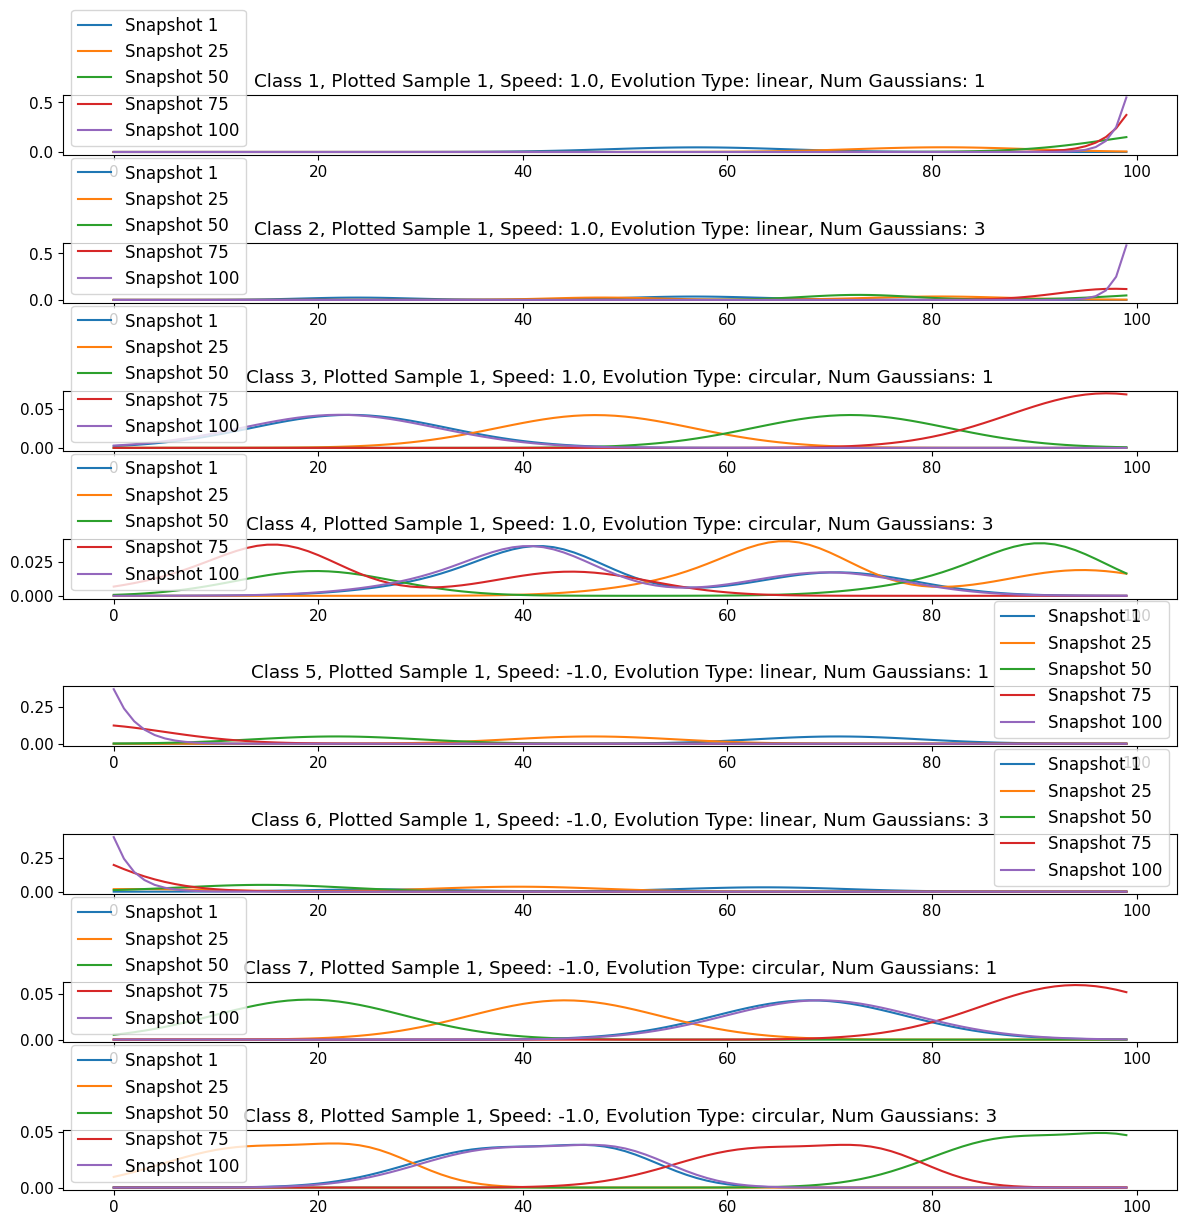

In [48]:
# Example usage with the labels
num_samples_per_class=5
num_timesteps=100
support_size=100
num_gaussians=[1, 3]
evolution_types=["linear", "circular"]
speeds=[1.0, -1.0]
seed = 42

data,y_speed, y_evotype, y_numgaussians = generate_gaussian_mixture_data(\
    num_samples_per_class,num_timesteps,support_size,num_gaussians,evolution_types,speeds,seed=seed)
plot_samples(data, num_snapshots=5, y_speed=y_speed, y_evotype=y_evotype, y_numgaussians=y_numgaussians,
             speeds=speeds,evolution_types=evolution_types,num_gaussians=num_gaussians)

In [49]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
from sta import sta_matrix, sdtw_matrix

In [50]:
def compute_distance_matrix_abs_distance(support_size):
    # Assuming you want the pairwise distances between the points in the support
    support_points = np.arange(support_size).reshape(-1, 1)
    distance_matrix = np.abs(support_points - support_points.T)
    return distance_matrix

In [51]:
# Modify depending on your hardware
n_gpu_devices = 1

In [52]:
def run_tsne_gaussians(data,y_speed, y_evotype, y_numgaussians,num_gaussians,\
                    evolution_types,speeds,betas=[0,0.1],epsilon=0.2,gamma=1.):
    
    # to avoid numerical errors with Sinkhorn, add 1e-3
    data = data + 1e-3
    num_classes, num_samples_per_class, num_timesteps, support_size = data.shape

    # Reshape data to match the expected shape
    data_reshaped = data.reshape(num_classes * num_samples_per_class, num_timesteps, support_size)

    experiment = dict(
        gaussian_data=data,
        y_speed=y_speed,
        y_evotype=y_evotype,
        y_numgaussians=y_numgaussians,
        betas=betas)
    M_=compute_distance_matrix_abs_distance(support_size)
    M = M_ / np.median(M_)
    K = np.exp(- M / epsilon)

    print('----Gaussian mixture signals are the training data for t-SNE-----')
    print('n_samples=', num_classes*num_samples_per_class)
    print('num_timesteps=', num_timesteps)
    print('dimension=', support_size)
    print('-------------------------------------')

    params = dict(K=K,epsilon=epsilon, gamma=gamma, n_jobs=4, n_gpu_devices=1)

    # Clear GPU memory
    # torch.cuda.empty_cache()

    # Compute STA distance matrix
    print('-----Starting sta_matrix computation-------')
    precomputed = sta_matrix(data_reshaped, betas, **params)
    print('-----sta_matrix computed -------')
    print('precomputed sta_matrix has shape', precomputed.shape)

    # Clear GPU memory
    # torch.cuda.empty_cache()

    experiment["sta"] = dict()
    for beta, train_ in zip(betas, precomputed):
        train = train_.copy()
        # Shift the distance to avoid negative values with large betas
        train -= train.min()
        tsne_data = TSNE(metric="precomputed", perplexity=30, init='random').fit_transform(train)
        experiment["sta"][beta] = tsne_data

    method = "soft"
    experiment["soft"] = dict()
    for beta in betas:
        precomputed = sdtw_matrix(data_reshaped, beta, n_jobs=10)
        train = precomputed.copy()
        # Shift the distance to avoid negative values with large betas
        train -= train.min()
        tsne_data = TSNE(metric="precomputed", perplexity=30, init='random').fit_transform(train)
        experiment[method][beta] = tsne_data

    expe_filename = f"data/tsne-gaussians_ns{num_samples_per_class}_nt{num_timesteps}_b{'_'.join(map(str, betas))}_s{'_'.join(map(str, speeds))}_ng{'_'.join(map(str, num_gaussians))}_{'_'.join(map(str, evolution_types))}.pkl"
    with open(expe_filename, "wb") as expe_file:
        pickle.dump(experiment, expe_file)


In [53]:
betas=[0,0.1]
epsilon=0.2
gamma=1.
run_tsne_gaussians(data,y_speed, y_evotype, y_numgaussians,num_gaussians,\
                    evolution_types,speeds,betas=betas,epsilon=epsilon,gamma=gamma)

----Gaussian mixture signals are the training data for t-SNE-----
n_samples= 40
num_timesteps= 100
dimension= 100
-------------------------------------
-----Starting sta_matrix computation-------
Doing 0 / 40 ...
Doing 39 / 40 ...
Doing 1 / 40 ...
Doing 38 / 40 ...
Doing 2 / 40 ...
Doing 37 / 40 ...
Doing 3 / 40 ...
Doing 36 / 40 ...
Doing 4 / 40 ...
Doing 35 / 40 ...
Doing 5 / 40 ...
Doing 34 / 40 ...
Doing 6 / 40 ...
Doing 33 / 40 ...
Doing 7 / 40 ...
Doing 32 / 40 ...
Doing 8 / 40 ...
Doing 31 / 40 ...
Doing 9 / 40 ...
Doing 30 / 40 ...
Doing 10 / 40 ...
Doing 29 / 40 ...
Doing 11 / 40 ...
Doing 28 / 40 ...
Doing 12 / 40 ...
Doing 27 / 40 ...
Doing 13 / 40 ...
Doing 26 / 40 ...
Doing 14 / 40 ...
Doing 25 / 40 ...
Doing 15 / 40 ...
Doing 24 / 40 ...
Doing 16 / 40 ...
Doing 23 / 40 ...
Doing 17 / 40 ...
Doing 22 / 40 ...
Doing 18 / 40 ...
Doing 21 / 40 ...
Doing 19 / 40 ...
Doing 20 / 40 ...
-----sta_matrix computed -------
precomputed sta_matrix has shape (2, 40, 40)
Softdtw out of 0

In [54]:
from matplotlib import pyplot as plt
import pickle
import numpy as np
from matplotlib.lines import Line2D

def plot_tsne_results(data, num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types):
    fontsize = 11
    params = {'axes.labelsize': fontsize + 2,
              'font.size': fontsize,
              'legend.fontsize': fontsize + 1,
              'xtick.labelsize': fontsize,
              'ytick.labelsize': fontsize,
              'pdf.fonttype': 42}
    plt.rcParams.update(params)

    expe_filename = get_expe_filename(num_samples_per_class, num_timesteps, betas, speeds, num_gaussians, evolution_types)
    data_expe_filename = f'data/{expe_filename}'
    fig_expe_filename_png = f'fig/{expe_filename.replace(".pkl", ".png")}'

    expe_file = open(data_expe_filename, "rb")
    experiment = pickle.load(expe_file)

    y_speed = experiment["y_speed"]
    speed_mapping = {speed: idx for idx, speed in enumerate(sorted(set(speeds)))}

    y_evotype = experiment["y_evotype"]
    evotype_mapping = {'linear': 0, 'circular': 1}

    y_numgaussians = experiment["y_numgaussians"]

    methods = ["soft", "sta"]

    color_base = np.array(["indianred", "cornflowerblue"])
    colors = color_base[np.array([speed_mapping[speed] for speed in y_speed])]

    marker_base = np.array(["+", "o"])
    markers = np.array([marker_base[evotype_mapping[evotype]] for evotype in y_evotype])

    alpha_base=[0.4,1]
    alphas = [0.4 if num_gaussian == 1 else 1 for num_gaussian in y_numgaussians]

    titles = ["Soft-DTW", "STA"]
    
    color_names = ["Speed 1.0", "Speed -1.0"]
    marker_names = ["Evolution type linear", "Evolution type circular"]
    num_gaussians_names = ["1 Gaussian", "3 Gaussians"]

    legend_entries = []
    for color, color_name in zip(color_base, color_names):
        for marker, marker_name in zip(marker_base, marker_names):
            for alpha, num_gaussians_name in zip(alpha_base, num_gaussians_names):
                label = f"{color_name}, {marker_name}, {num_gaussians_name} (Alpha {alpha:.2f})"
                if marker == "+":
                    marker_symbol = r"$\oplus$"
                else:
                    marker_symbol = marker
                legend_entries.append(Line2D([0], [0], color="w", markerfacecolor=color, marker=marker_symbol, alpha=alpha,
                                label=label, markersize=18))

    f, axes = plt.subplots(2, 2, figsize=(10, 10))

    for j, beta in enumerate(betas):
        for i, (method, title) in enumerate(zip(methods, titles)):
            method_data = experiment[method]
            tsne_data = method_data[beta]
            ax = axes[j, i]
            for point, color, marker, alpha in zip(tsne_data, colors, markers, alphas):
                ax.scatter(point[0], point[1], color=color, s=100, marker=marker, alpha=alpha)
            ax.set_xticks([])
            ax.set_yticks([])

            if i == 0:
                ax.set_ylabel(r"$\beta = %s$" % (np.round(beta, 1)))
            if j == 0:
                ax.set_title(title)

    ax.legend(handles=legend_entries, loc="best", bbox_to_anchor=(1, 1), title="Legend", frameon=False)

    # Save only in PNG format
    plt.savefig(fig_expe_filename_png, bbox_inches='tight')
    plt.show()


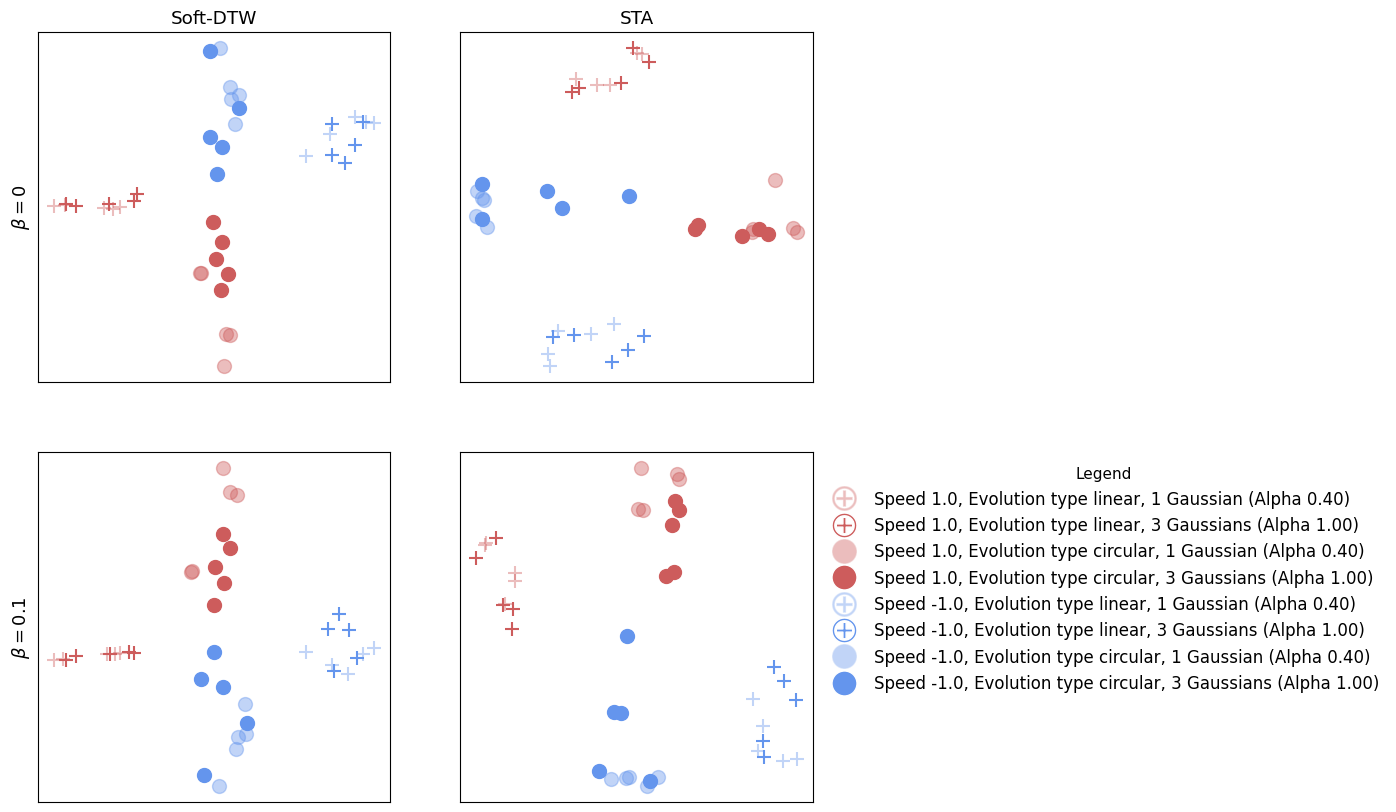

In [55]:
plot_tsne_results(data, num_samples_per_class,\
  num_timesteps, [0, 0.1], speeds, num_gaussians, evolution_types)

## Second experiment: 4 classes

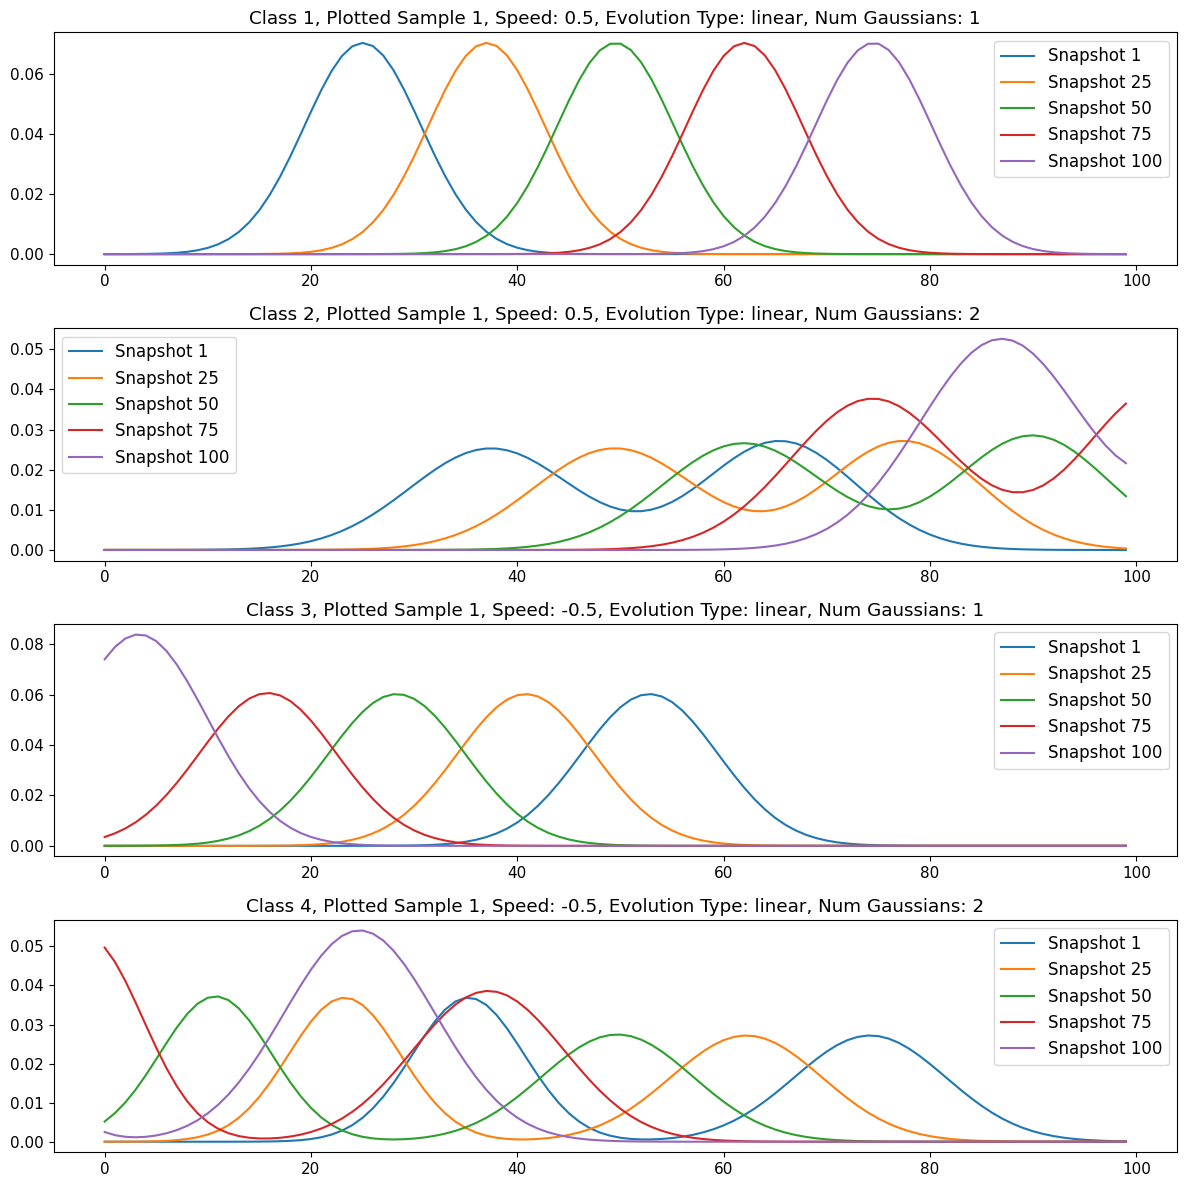

In [56]:
# Example usage with the labels
num_samples_per_class=10
num_timesteps=100
support_size=100
num_gaussians=[1, 2]
evolution_types=["linear"]
speeds=[0.5, -0.5]
seed = 42

data,y_speed, y_evotype, y_numgaussians =generate_gaussian_mixture_data(num_samples_per_class=num_samples_per_class, num_timesteps=num_timesteps, support_size=support_size,\
num_gaussians=num_gaussians, evolution_types=evolution_types, speeds=speeds, seed=None)
plot_samples(data, num_snapshots=5, y_speed=y_speed, y_evotype=y_evotype, y_numgaussians=y_numgaussians,
             speeds=speeds,evolution_types=evolution_types,num_gaussians=num_gaussians)


In [57]:
betas=[0,0.1]
epsilon=0.2
gamma=1.
run_tsne_gaussians(data,y_speed, y_evotype, y_numgaussians,num_gaussians,\
                    evolution_types,speeds,betas=betas,epsilon=epsilon,gamma=gamma)

----Gaussian mixture signals are the training data for t-SNE-----
n_samples= 40
num_timesteps= 100
dimension= 100
-------------------------------------
-----Starting sta_matrix computation-------
Doing 0 / 40 ...
Doing 39 / 40 ...
Doing 1 / 40 ...
Doing 38 / 40 ...
Doing 2 / 40 ...
Doing 37 / 40 ...
Doing 3 / 40 ...
Doing 36 / 40 ...
Doing 4 / 40 ...
Doing 35 / 40 ...
Doing 5 / 40 ...
Doing 34 / 40 ...
Doing 6 / 40 ...
Doing 33 / 40 ...
Doing 7 / 40 ...
Doing 32 / 40 ...
Doing 8 / 40 ...
Doing 31 / 40 ...
Doing 9 / 40 ...
Doing 30 / 40 ...
Doing 10 / 40 ...
Doing 29 / 40 ...
Doing 11 / 40 ...
Doing 28 / 40 ...
Doing 12 / 40 ...
Doing 27 / 40 ...
Doing 13 / 40 ...
Doing 26 / 40 ...
Doing 14 / 40 ...
Doing 25 / 40 ...
Doing 15 / 40 ...
Doing 24 / 40 ...
Doing 16 / 40 ...
Doing 23 / 40 ...
Doing 17 / 40 ...
Doing 22 / 40 ...
Doing 18 / 40 ...
Doing 21 / 40 ...
Doing 19 / 40 ...
Doing 20 / 40 ...
-----sta_matrix computed -------
precomputed sta_matrix has shape (2, 40, 40)
Softdtw out of 0

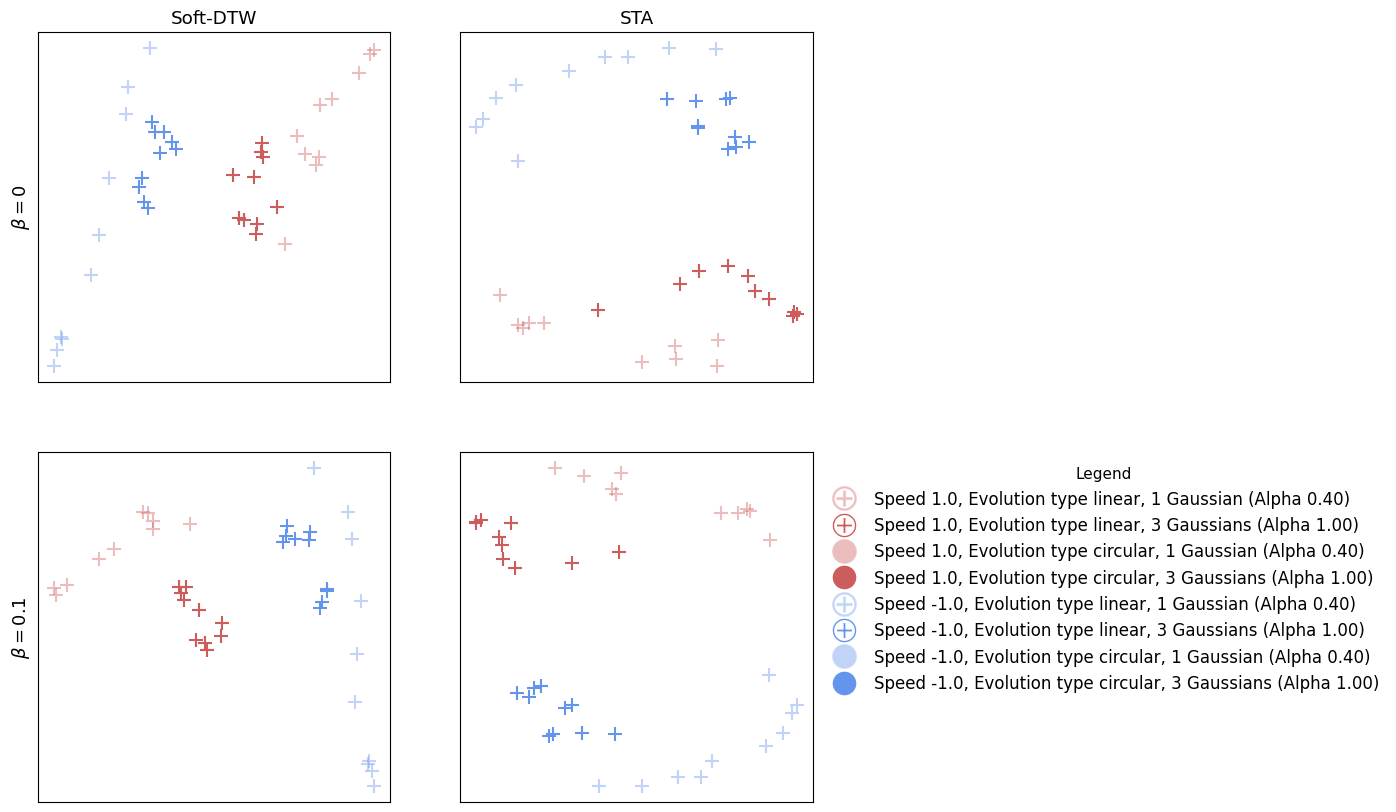

In [58]:
plot_tsne_results(data, num_samples_per_class,\
  num_timesteps, [0, 0.1], speeds, num_gaussians, evolution_types)

## Third experiment: 4 classes

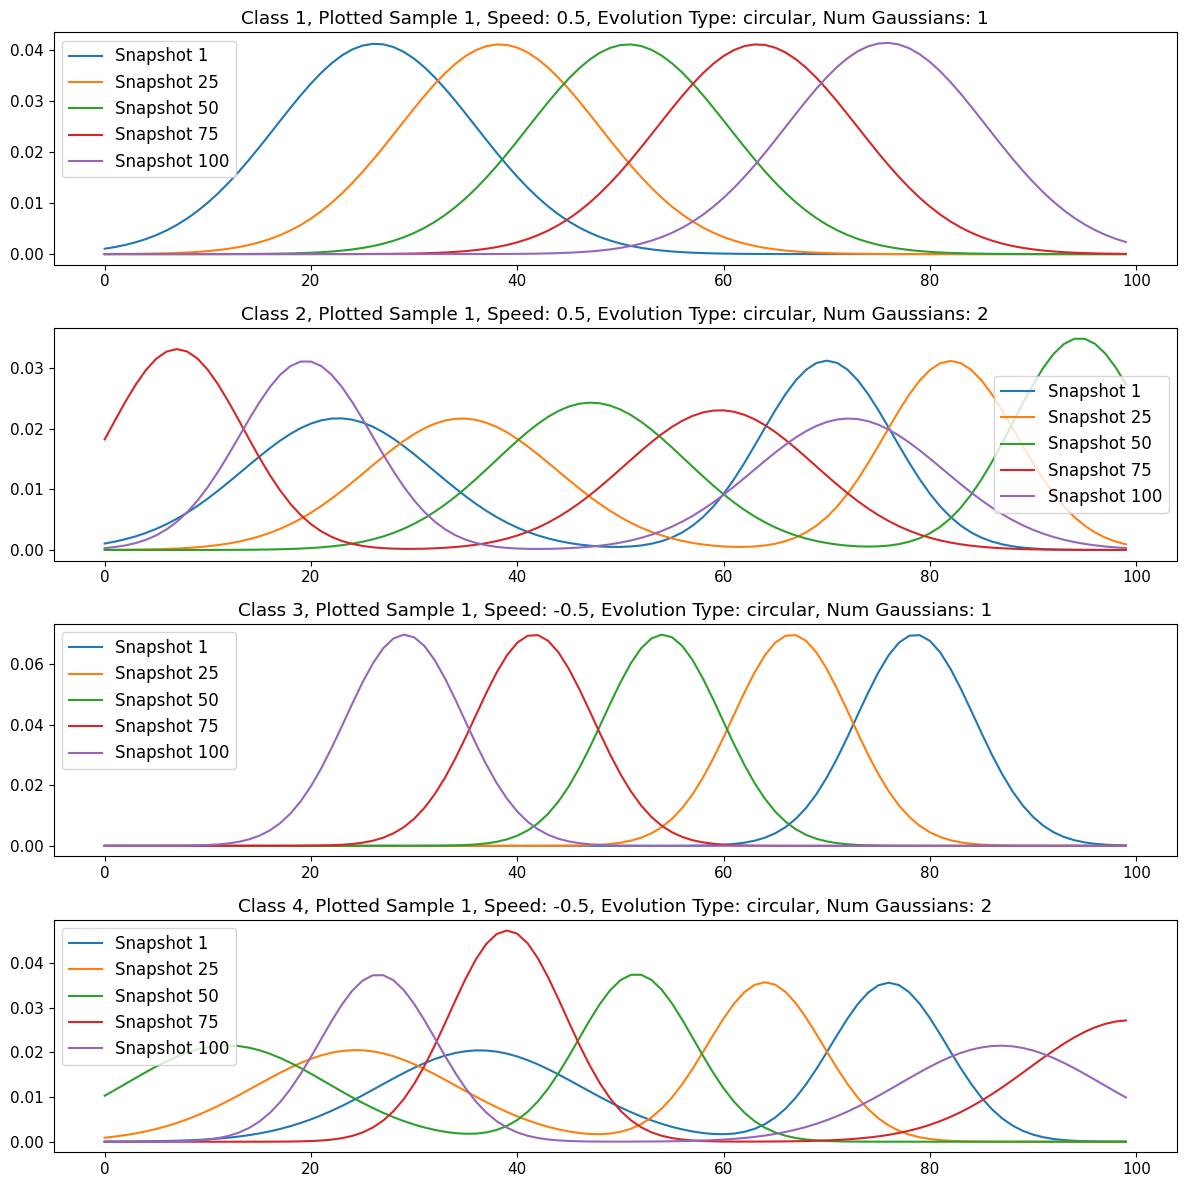

In [59]:
# Example usage with the labels
num_samples_per_class=10
num_timesteps=100
support_size=100
num_gaussians=[1, 2]
evolution_types=["circular"]
speeds=[0.5, -0.5]
seed = 42

data,y_speed, y_evotype, y_numgaussians =generate_gaussian_mixture_data(num_samples_per_class=num_samples_per_class, num_timesteps=num_timesteps, support_size=support_size,\
num_gaussians=num_gaussians, evolution_types=evolution_types, speeds=speeds, seed=None)
plot_samples(data, num_snapshots=5, y_speed=y_speed, y_evotype=y_evotype, y_numgaussians=y_numgaussians,
             speeds=speeds,evolution_types=evolution_types,num_gaussians=num_gaussians)


In [60]:
betas=[0,0.1]
epsilon=0.2
gamma=1.
run_tsne_gaussians(data,y_speed, y_evotype, y_numgaussians,num_gaussians,\
                    evolution_types,speeds,betas=betas,epsilon=epsilon,gamma=gamma)

----Gaussian mixture signals are the training data for t-SNE-----
n_samples= 40
num_timesteps= 100
dimension= 100
-------------------------------------
-----Starting sta_matrix computation-------
Doing 0 / 40 ...Doing 39 / 40 ...

Doing 1 / 40 ...
Doing 38 / 40 ...
Doing 2 / 40 ...
Doing 37 / 40 ...
Doing 3 / 40 ...
Doing 36 / 40 ...
Doing 4 / 40 ...
Doing 35 / 40 ...
Doing 5 / 40 ...
Doing 34 / 40 ...
Doing 6 / 40 ...
Doing 33 / 40 ...
Doing 7 / 40 ...
Doing 32 / 40 ...
Doing 8 / 40 ...
Doing 31 / 40 ...
Doing 9 / 40 ...
Doing 30 / 40 ...
Doing 10 / 40 ...
Doing 29 / 40 ...
Doing 11 / 40 ...
Doing 28 / 40 ...
Doing 12 / 40 ...
Doing 27 / 40 ...
Doing 13 / 40 ...
Doing 26 / 40 ...
Doing 14 / 40 ...
Doing 25 / 40 ...
Doing 15 / 40 ...
Doing 24 / 40 ...
Doing 16 / 40 ...
Doing 23 / 40 ...
Doing 17 / 40 ...
Doing 22 / 40 ...
Doing 18 / 40 ...
Doing 21 / 40 ...
Doing 19 / 40 ...
Doing 20 / 40 ...
-----sta_matrix computed -------
precomputed sta_matrix has shape (2, 40, 40)
Softdtw out of 0

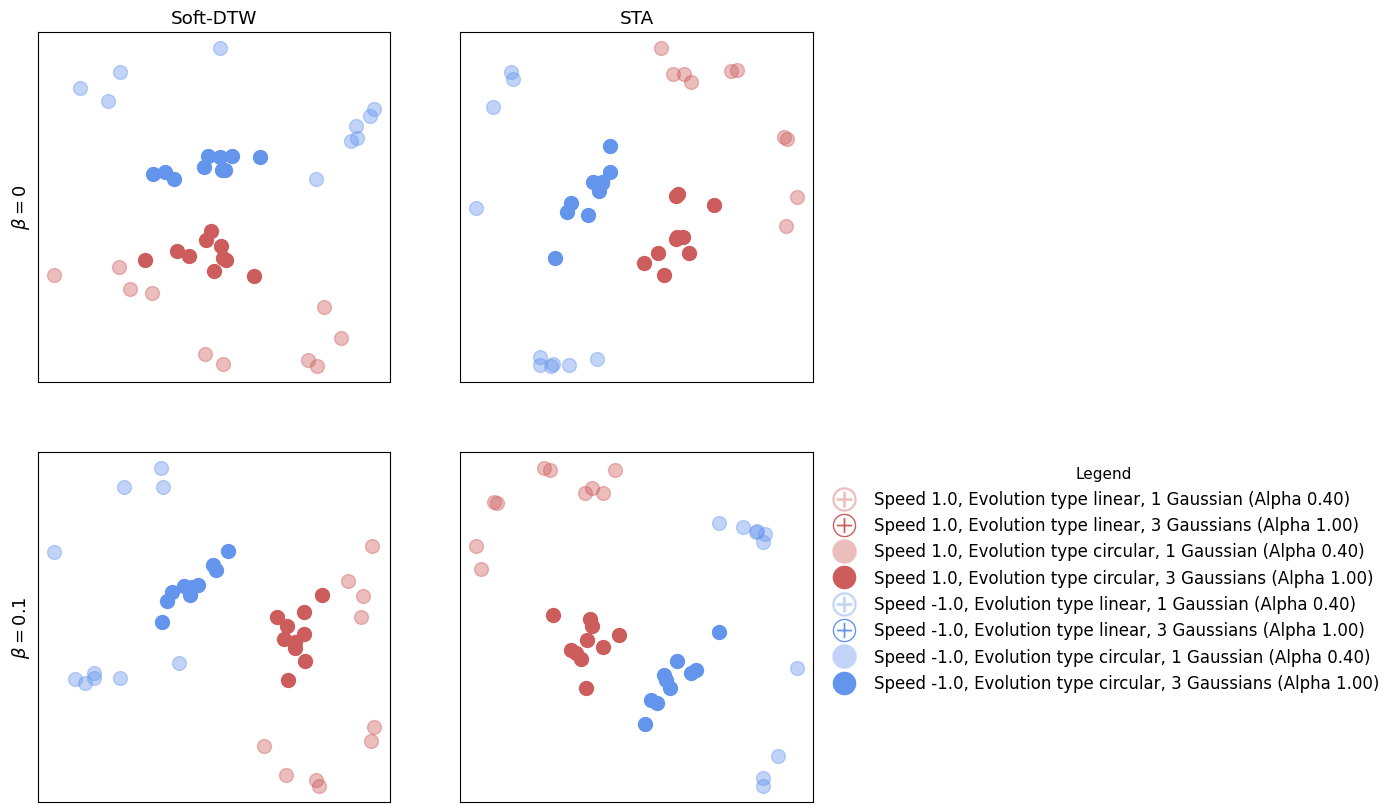

In [61]:
plot_tsne_results(data, num_samples_per_class,\
  num_timesteps, [0, 0.1], speeds, num_gaussians, evolution_types)